In [5]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas
import importlib
#from toggle_cell import hide_cell 
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)
import root_pandas,glob

def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

plt.rcParams['savefig.bbox']='tight'
import misc_util
importlib.reload(misc_util)
import gc

#import ROOT
import collections
#pdg = ROOT.TDatabasePDG()

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [6]:
#produce plots similar to those in NC-DIS paper https://journals.aps.org/prd/pdf/10.1103/PhysRevD.102.074015

In [263]:
#df_all = root_pandas.read_root("../CC_DIS_EIC_1.5M_all.root")
#df_all = root_pandas.read_root("../CC_DIS_EIC_test_10k.root")

df_all = root_pandas.read_root("../allsilicon_tuples_test_oldmatch.root")

In [264]:
print(df_all.memory_usage().sum()/1024**3, "GB")
ints = df_all.select_dtypes(include=['int64']).columns.tolist()
df_all[ints] = df_all[ints].astype('int16')
print(df_all.memory_usage().sum()/1024**3, "GB")
#for col in "Hadron_i Jet_i Neutrino_PID Quark_PID GenJet_NCharged GenJet_NNeutrals Jet_NCharged Jet_NNeutrals".split():
    

0.04466225206851959 GB
0.04466225206851959 GB


In [265]:
print(df_all.memory_usage().sum()/1024**3, "GB")

0.04466225206851959 GB


In [266]:
import gc
gc.collect()

3322

In [267]:
print(list(df_all.columns))

['Jet_PT', 'Jet_Eta', 'Jet_Phi', 'Jet_Mass', 'Jet_DeltaEta', 'Jet_DeltaPhi', 'Jet_NCharged', 'Jet_NNeutrals', 'Jet_NeutralEnergyFraction', 'Jet_ChargedEnergyFraction', 'GenJet_PT', 'GenJet_Eta', 'GenJet_Phi', 'GenJet_Mass', 'GenJet_DeltaEta', 'GenJet_DeltaPhi', 'GenJet_NCharged', 'GenJet_NNeutrals', 'GenJet_NeutralEnergyFraction', 'GenJet_ChargedEnergyFraction', 'Neutrino_PID', 'Neutrino_Status', 'Neutrino_E', 'Neutrino_Px', 'Neutrino_Py', 'Neutrino_Pz', 'Neutrino_PT', 'Neutrino_Eta', 'Quark_PID', 'Quark_Status', 'Quark_E', 'Quark_Px', 'Quark_Py', 'Quark_Pz', 'Quark_PT', 'Quark_Eta', 'MissingET_MET', 'MissingET_Eta', 'MissingET_Phi', 'GenMissingET_MET', 'GenMissingET_Eta', 'GenMissingET_Phi', 'Event_Number', 'Gen_W2', 'Gen_x', 'Gen_y', 'Gen_Q2', 'GenJet_size', 'Hadron_PID', 'Hadron_Charge', 'Hadron_P', 'Hadron_PT', 'Hadron_Eta', 'Hadron_Phi', 'Hadron_E', 'Hadron_ET', 'Hadron_Eem', 'Hadron_Ehad', 'GenHadron_PID', 'GenHadron_Charge', 'GenHadron_P', 'GenHadron_PT', 'GenHadron_Eta', 'GenHa

In [268]:
if not "Hadron_i" in df_all.columns:
    df_all['Hadron_i'] = df_all.eval("Jet_i-Jet_i")
df_jets = df_all.query('(Jet_PT > 0 or GenJet_PT>0) and Hadron_i == 0')
df_rg = df_all.query('Jet_E > 0 and GenJet_E>0 and Hadron_i == 0')
df_nu = df_all.query("Jet_i == 0 and Hadron_i == 0") #just neutrinos.  
df_hadrons = df_all.query("Hadron_P>0 or Hadron_E>0")
print([len(a) for a in (df_all,df_jets,df_rg,df_nu,df_hadrons)])
del df_all

[62280, 11911, 6493, 10000, 55300]


In [269]:
# fig 1 is feynman diagram (not included here)

In [270]:
def hack_legend(labels = 'Pythia;theory'.split(';'),*varg,**kwarg):
    #create a legend with lines instead of boxes
    handle1 = matplotlib.lines.Line2D([], [], c='tab:blue')
    handle2 = matplotlib.lines.Line2D([], [], c='tab:orange')
    plt.legend(handles=[handle1, handle2],labels=labels,framealpha=0,**kwarg)

In [271]:
def purity_plot(df, expr,genExpr,partitions,**kwarg):
    xs = []
    ys = []
    dys = []
    dxs = []
    for i in range(len(partitions)-1):
        x=(partitions[i]+partitions[i+1])/2
        dx = (partitions[i+1]-partitions[i])/2
        num = len(df.query(f"{expr}>={partitions[i]} and {expr}<{partitions[i+1]} and {genExpr}>={partitions[i]} and {genExpr}<{partitions[i+1]}"))
        denom = len(df.query(f"{expr}>={partitions[i]} and {expr}<{partitions[i+1]}"))
        if denom == 0:
            continue
        y =num/denom
        dy = np.sqrt(((denom-num)*num)/denom**3)
        
        xs.append(x)
        ys.append(y)
        dys.append(dy)
        dxs.append(dx)
    print(ys)
    plt.errorbar(xs,ys,dys,dxs,**kwarg)

In [272]:
#corresponds to fig. 3 of NC-DIS paper.  Added an additional panel for pTjet
#q2min, y_range,pt_range = 100,(.1,.85),(15,20)
def fig3(q2min=100, y_range=(0,1),
         nupt_range=(0,50),jetpt_range=(0,50),partitions = [0,1,2,3.5,5.5,8,10.5],
         expr_recon="qT",expr_gen='Gen_qT',ylbl="$1/\\sigma\\times d\\sigma/dq_T$",xlbl="$q_T$ [GeV]"):
   


    q = f'Gen_Q2>{q2min} and Gen_y>{y_range[0]} and Gen_y<{y_range[1]} and GenMissingET_MET>{nupt_range[0]} and GenJet_PT>{jetpt_range[0]} '
    if nupt_range[1] is not None:
        q += f" and GenMissingET_MET<{nupt_range[1]}"
    if jetpt_range[1] is not None:
        q += f" and GenJet_PT<{jetpt_range[1]}"
        
    df = df_jets.query(q + " and Jet_PT>0 and GenJet_PT>0 and qT>0")
    
    fig,axs = plt.subplots(3,1, figsize=(7,12),sharex='all')
    fig.subplots_adjust(hspace=0)
    
    plt.sca(axs[0])
    plt.hist2d(df.eval(expr_gen),df.eval(expr_recon), bins=100, range=[(partitions[0],partitions[-1])]*2, norm=mpl.colors.LogNorm())
    plt.gca().set_ylabel(f"{xlbl} recon")
    
    
    axs[0].tick_params(bottom=True,direction='inout')
    axs[1].tick_params(top=True,direction='inout')
    
    plt.sca(axs[1])
    plt.hist(df.eval(expr_recon),density=True,histtype='step',bins=partitions)

    plt.hist(df.eval(expr_gen),density=True,histtype='step',bins=partitions)
    #plt.gca().set_xlim(0.05,1.2)

    txt = f"$Q^2>{q2min}$ GeV$^2$\n"
    if nupt_range[1] is not None:
        txt += f"${nuput_range[0]}<p^{{\\nu}}_T<{nupt_range[1]}$ GeV\n"
    else:
        txt += f"$p^{{\\nu}}_T>{nupt_range[0]}$ GeV\n"
    if jetpt_range[1] is not None:
        txt += f"${jetpt_range[0]}<p^{{\\mathrm{{jet}}}}_T < {jetpt_range[0]}$ GeV\n"
    else :
        txt += f"$p^{{\\mathrm{{jet}}}}_T > {jetpt_range[0]}$ GeV\n"
    txt += "$%s<y<%s$" % y_range
    
    #txt = "$Q^2>%s$ GeV$^2$\n$%s<p^{\\nu}_T<%s$ GeV\n$%s<p^{\\mathrm{jet}}_T<%s$ GeV\n$%s<y<%s$"%(q2min,*nupt_range,*jetpt_range,*y_range)
    txt+= "\n$<Q^2>$=%.0f GeV$^2$\n$<x_B>$=%.2f" %(np.mean(df.Gen_Q2),np.mean(df.Gen_x))
    plt.text(0.6,0.3,txt,transform=plt.gca().transAxes)

    hack_legend(loc = (0.25,.7),labels='Recon. Gen.'.split())
    plt.gca().set_ylabel(ylbl)
    plt.gca().set_xlabel(xlbl)


    #ax2 = axs[1].twinx()
    #ax2.tick_params(labelcolor='r')
    
    plt.sca(axs[2])
    purity_plot(df,expr_recon,expr_gen,partitions,color='r',marker='o',linestyle='')
    plt.gca().set_xlabel(xlbl)
    plt.gca().set_ylabel("purity")   
    plt.gca().set_ylim(0, 1)

[0.6192739844425238, 0.5894378194207837, 0.5840336134453782, 0.6, 0.7142857142857143]


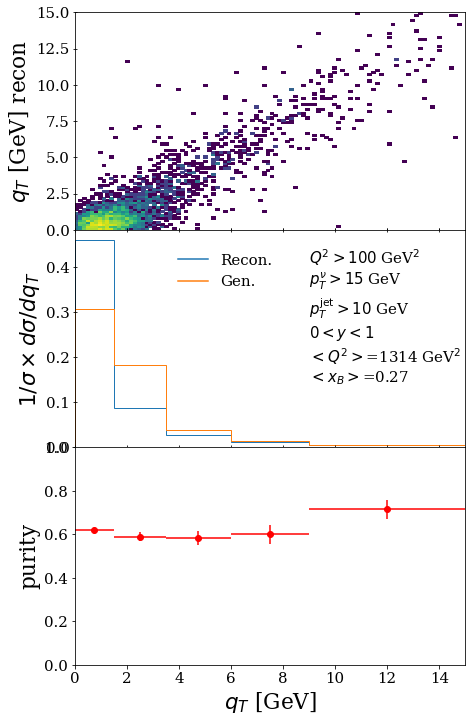

In [273]:
#fig3()
#plt.savefig("images/qT.png")
#fig3(partitions = [0,1.5,3.25,5.5,8,10.5])
#plt.savefig("images/qT.png")
#fig3(nupt_range=(15,50),partitions = [0,1.5,3.25,5.5,8,10.5])
#plt.savefig("images/qT.png")
#fig3(jetpt_range=(10,50),partitions = [0,1.5,3.25,5.5,8,10.5])
#plt.savefig("images/qT.png")
fig3(jetpt_range=(10,None),nupt_range=(15,None),partitions = [0,1.5,3.5,6,9,15])
#fig3(jetpt_range=(10,None),nupt_range=(15,None),partitions = [0,1.5,3.5,6,9,15])
#fig3(jetpt_range=(15,None),nupt_range=(15,None),partitions = [0,1.5,3.5,6,9,15])
plt.savefig("images/qT.png")

[0.6608161474330847, 0.6477272727272727, 0.5821596244131455, 0.5]


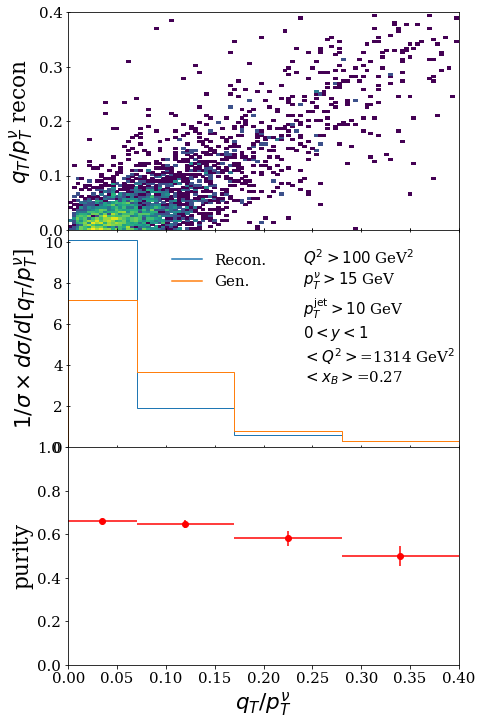

In [274]:

fig3(jetpt_range=(10,None),nupt_range=(15,None),partitions = [0,.07,.17,.28,.4],
     expr_recon='qT/JB_MET',expr_gen='Gen_qT/GenMissingET_MET',
     ylbl="$1/\\sigma\\times d\\sigma/d[q_T/p^\\nu_T$]",xlbl="$q_T/p^\\nu_T$")

plt.savefig("images/qToverpTnu.png")

In [275]:
#expr = "sqrt(GenMissingET_MET**2+GenJet_PT**2+2*GenMissingET_MET*GenJet_PT*cos(GenJet_Phi-GenMissingET_Phi))/GenMissingET_MET"
#expr = expr.replace("Gen","") + "-"+ "QuarkI_PT/Neutrino_PT"
#resolution_plot(expr, "$q_T/p^\\nu_T$ resolution","gen. $E_{\\mathrm{jet}}$ (GeV)", "GenJet_E",condition='GenJet_E>20')

In [276]:
# fig 8 is event display (not included here)

In [277]:
#mean and sigma
def resolution_plot_mean_sigma(yexpr, ylbl,xlbl="gen. MET (GeV)", 
                               xexpr="GenMissingET_MET",xrange=None, 
                               condition = None,label=None,nbins=20,
                              color = "tab:blue",df = df_rg):
    #.query("Jet_PT>10 and GenJet_PT>10 and Jet_E>0")
    if condition is not None:
        df = df.query(condition)
        print("entries in slice", len(df))
    if(len(df) == 0):
        return
    
    import matplotlib as mpl
    xv = df.eval(xexpr)
    yv = df.eval(yexpr)
    #print(np.mean(yv))
    if xrange is None:
        mn,mx = xv.quantile(.01),xv.quantile(.99)
        if mn > 0 and mn < mx*.12:
            mn = 0
    else:
        mn,mx=xrange
    
    ymn = yv.quantile(.05)
    ymx = yv.quantile(.95)
    
    if(ymn>-.1*ymx):
        ymn = -.1*ymx
    
    #plt.hist2d(xv,yv, 
    #           bins=100,range=([mn,mx],[ymn,ymx]), norm=mpl.colors.LogNorm())
    #plt.gca().set_ylabel(ylbl)

    #plt.axhline(0,linestyle='--',color='0.3',linewidth=2)
    x,y,dy = [],[],[]
    
    for i in range(1,nbins):
        mni,mxi = i*(mx-mn)/nbins+mn,(i+1)*(mx-mn)/nbins+mn
        #print(mn,mx)
        df_slice = df.query("%s>%s and %s<%s" \
                               %(xexpr,mni,xexpr,mxi))
        if len(df_slice)<30:
            continue
        x.append((i+0.5)*(mx-mn)/nbins+mn)
        mean,std = misc_util.getmeanstd(df_slice,yexpr)
        #print(mean,std)
        y.append(mean)
        dy.append(std)
        del df_slice
    gc.collect()

    plt.plot(x,y,label=None, color=color,linestyle='--')
    plt.plot(x,dy,label=label, color=color,linestyle='-')
    plt.grid(linestyle=':')
    plt.axhline(0,linestyle=':',color='0.7')
    plt.gca().set_ylabel(ylbl)
    plt.gca().set_xlabel(xlbl)
    plt.gca().set_xlim(*xrange)
    plt.axhline(0,linestyle=':',color='0.7')
    
    plt.legend()
    plt.grid(linestyle=':')
    del df

(array([ 21.,  42.,  81., 141., 213., 276., 369., 494., 565., 610., 737.,
        737., 577., 508., 369., 285., 193., 140.,  94.,  41.]),
 array([-1.55701351, -1.30439874, -1.05178397, -0.79916919, -0.54655442,
        -0.29393965, -0.04132488,  0.21128989,  0.46390467,  0.71651944,
         0.96913421,  1.22174898,  1.47436376,  1.72697853,  1.9795933 ,
         2.23220807,  2.48482285,  2.73743762,  2.99005239,  3.24266716,
         3.49528193]),
 <a list of 20 Patch objects>)

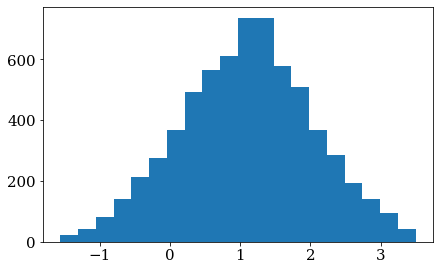

In [278]:
plt.hist(df_rg.Jet_Eta,bins=20)

entries in slice 799
entries in slice 2093
entries in slice 3142
entries in slice 442


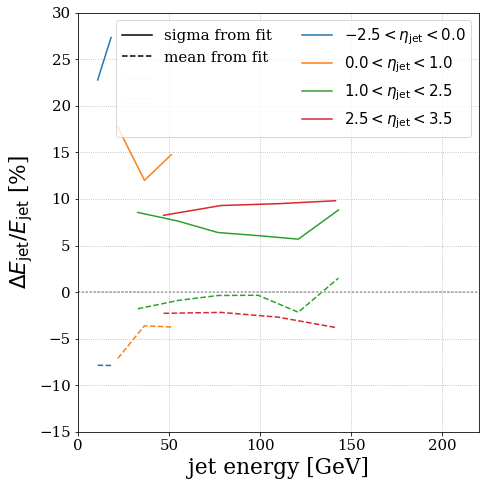

In [279]:
fig,axs = plt.subplots(1,1, figsize=(7,7))

#these are just to put in the legend
plt.plot([],[], color='k', linestyle='-', label="sigma from fit")
plt.plot([],[], color='k', linestyle='--', label="mean from fit")
plt.plot([],[], color='0.99', linestyle='-', label=" ")
plt.plot([],[], color='0.99', linestyle='-', label=" ")

colors = ["tab:"+a for a in "blue orange green red".split()]
for i,(etamin,etamax) in enumerate([(-2.5,0.0),(0.0, 1.0),(1.0,2.5),(2.5,3.5)]):
    resolution_plot_mean_sigma("100*(Jet_E-GenJet_E)/GenJet_E","$\Delta E_{\mathrm{jet}}/E_{\mathrm{jet}}$ [%]",
                               xlbl="jet energy [GeV]", xexpr="GenJet_E", 
                               condition = f"GenJet_Eta>{etamin} and GenJet_Eta<{etamax}",
                               xrange=(0,220),label=f"${etamin}<\\eta_{{\\mathrm{{jet}}}}<{etamax}$",
                              nbins = 30 if i == 0 else 15 if i==1 else 10 if i==2 else 7, color=colors[i])
axs.set_ylim(-15,30)

plt.legend(ncol=2)
plt.tight_layout()
plt.savefig("images/jet_energy_resolutions_by_eta_slices.png")    

entries in slice 799
entries in slice 2093
entries in slice 3142
entries in slice 442


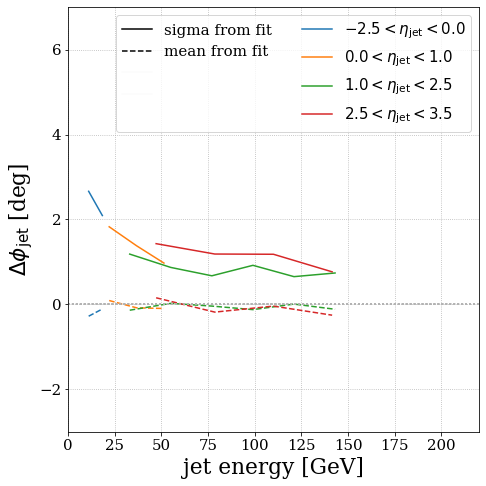

In [280]:
fig,axs = plt.subplots(1,1, figsize=(7,7))

#these are just to put in the legend
plt.plot([],[], color='k', linestyle='-', label="sigma from fit")
plt.plot([],[], color='k', linestyle='--', label="mean from fit")
plt.plot([],[], color='0.99', linestyle='-', label=" ")
plt.plot([],[], color='0.99', linestyle='-', label=" ")

colors = ["tab:"+a for a in "blue orange green red".split()]
for i,(etamin,etamax) in enumerate([(-2.5,0.0),(0.0, 1.0),(1.0,2.5),(2.5,3.5)]):
    resolution_plot_mean_sigma(f"{180/np.pi}*((GenJet_Phi-Jet_Phi)+(GenJet_Phi-Jet_Phi>{np.pi})*-{2*np.pi}+(GenJet_Phi-Jet_Phi<{-np.pi})*{2*np.pi})","$\Delta \phi_{\mathrm{jet}}$ [deg]",
                               xlbl="jet energy [GeV]", xexpr="GenJet_E", 
                               condition = f"GenJet_Eta>{etamin} and GenJet_Eta<{etamax}",
                               xrange=(0,220),label=f"${etamin}<\\eta_{{\\mathrm{{jet}}}}<{etamax}$",
                              nbins = 30 if i == 0 else 15 if i==1 else 10 if i==2 else 7, color=colors[i])
axs.set_ylim(-3,7)

plt.legend(ncol=2)
plt.tight_layout()
plt.savefig("images/jet_phi_resolutions_by_eta_slices.png")   

entries in slice 799
entries in slice 2093
entries in slice 3142
entries in slice 442


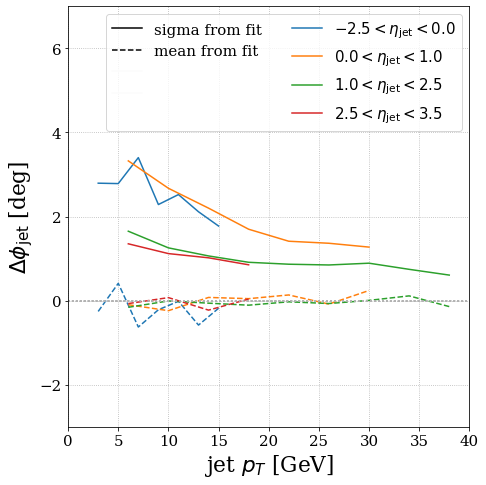

In [281]:
fig,axs = plt.subplots(1,1, figsize=(7,7))

#these are just to put in the legend
plt.plot([],[], color='k', linestyle='-', label="sigma from fit")
plt.plot([],[], color='k', linestyle='--', label="mean from fit")
plt.plot([],[], color='0.99', linestyle='-', label=" ")
plt.plot([],[], color='0.99', linestyle='-', label=" ")

colors = ["tab:"+a for a in "blue orange green red".split()]
for i,(etamin,etamax) in enumerate([(-2.5,0.0),(0.0, 1.0),(1.0,2.5),(2.5,3.5)]):
    resolution_plot_mean_sigma(f"{180/np.pi}*((GenJet_Phi-Jet_Phi)+(GenJet_Phi-Jet_Phi>{np.pi})*-{2*np.pi}+(GenJet_Phi-Jet_Phi<{-np.pi})*{2*np.pi})","$\Delta \phi_{\mathrm{jet}}$ [deg]",
                               xlbl="jet $p_T$ [GeV]", xexpr="GenJet_PT", 
                               condition = f"GenJet_Eta>{etamin} and GenJet_Eta<{etamax}",
                               xrange=(0,40),label=f"${etamin}<\\eta_{{\\mathrm{{jet}}}}<{etamax}$",
                              nbins = 10 if i >0 else 20, color=colors[i])
axs.set_ylim(-3,7)

plt.legend(ncol=2)
plt.tight_layout()
plt.savefig("images/jet_phi_resolutions_by_eta_slices_pt_bins.png")  

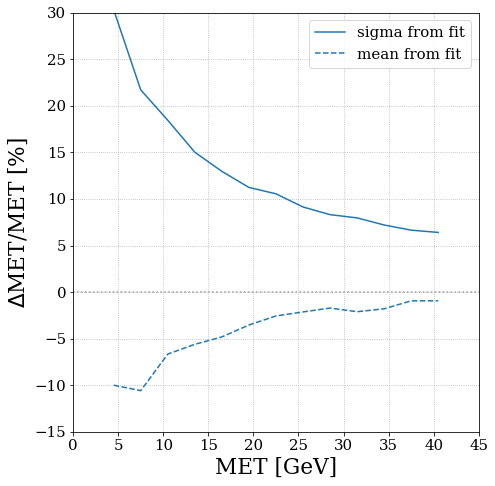

In [282]:
fig,axs = plt.subplots(1,1, figsize=(7,7))

#these are just to put in the legend
plt.plot([],[], color='tab:blue', linestyle='-', label="sigma from fit")
plt.plot([],[], color='tab:blue', linestyle='--', label="mean from fit")
#plt.plot([],[], color='0.99', linestyle='-', label=" ")
#plt.plot([],[], color='0.99', linestyle='-', label=" ")


resolution_plot_mean_sigma("100*(MissingET_MET-GenMissingET_MET)/GenMissingET_MET","$\Delta$MET/MET [%]",
                               xlbl="MET [GeV]", xexpr="GenMissingET_MET",
                               xrange=(0,45),label=None,
                              nbins = 15,df=df_nu)
axs.set_ylim(-15,30)

plt.legend(ncol=1)
plt.tight_layout()
plt.savefig("images/met_resolutions_by_eta_slices.png")  

In [58]:
#following the style of the neutral currents paper
def resolution_plot2(yexpr, ylbl,xlbl="generated jet energy [GeV]", xexpr="GenJet_E", 
                     condition = None,nbins=20,xrange=None,axs=None,makeLegend=True,
                    include_gauss=True, df = df_rg.query("Jet_PT>0 and GenJet_PT>10 and Jet_E>0"),include_std=True):
    
    if condition is not None:
        df = df.query(condition)
    if axs == None:
        fig,axs = plt.subplots(1,1, figsize=(7,7/golden))
    
    xv = df.eval(xexpr)
    yv = df.eval(yexpr)
    
    if xrange == None:
        mn,mx = xv.quantile(.03),xv.quantile(.97)
        if mn > 0 and mn < mx*.12:
            mn = 0
    else :
        mn,mx = xrange
    
    ymn = yv.quantile(.03)
    ymx = yv.quantile(.97)
    
    if(ymn>-.1*ymx):
        ymn = -.1*ymx
    #df = df[(yv>ymn)&(yv<ymx)]
    x,y,dy,ystd,dystd = [],[],[],[],[]
    for i in range(1,nbins):
        
        df_slice = df.query("%s>%s and %s<%s" \
                               %(xexpr,i*(mx-mn)/nbins+mn,xexpr,(i+1)*(mx-mn)/nbins+mn))
        if len(df_slice)<3:
            continue
        if include_gauss:
            mu,sigma = misc_util.getmeanstd(df_slice,yexpr)
            
            y.append(mu)
            dy.append(sigma)
        
        x.append((i+0.5)*(mx-mn)/nbins+mn)
        a = df_slice.eval(yexpr)
        a = a[(a>a.quantile(.0001)) & (a<a.quantile(.9999))]
        ystd.append(np.mean(a))
        dystd.append(np.std(a))
    if include_gauss:
        plt.plot(x,dy,linestyle='-',marker='o',markersize=5,linewidth=2,label = "Gaussian fit")
    if include_std:
        plt.plot(x,dystd,linestyle='-',marker='o',markersize=5,linewidth=2,label = "Standard deviation")
    if makeLegend:
        plt.legend(title='anti-$k_T$ $R$=1 jets',framealpha=0)
    plt.gca().set_ylabel(ylbl)
    plt.gca().set_xlabel(xlbl)
    plt.gca().set_ylim(0)
    #plt.grid(linestyle=':')
phistr = lambda expr : "(XXX - 2*3.141592653589793*(XXX>3.141592653589793) + 2*3.141592653589793*(XXX<-3.141592653589793))*180/3.141592653589793".replace("XXX",expr)

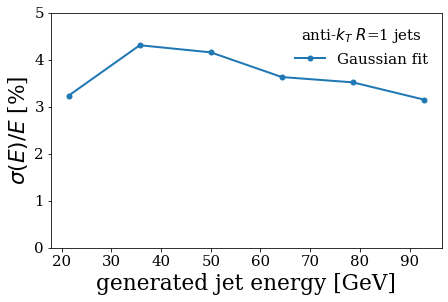

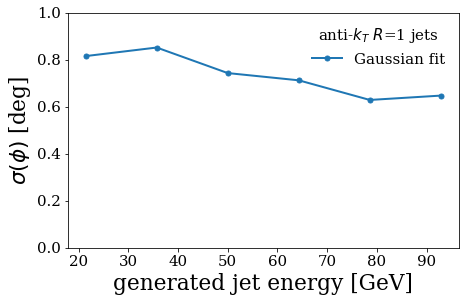

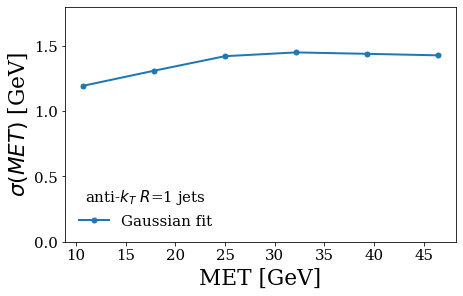

In [65]:
#corresponds to fig 9 of NC DIS paper

resolution_plot2("100*(GenJet_E-Jet_E)/GenJet_E", "$\\sigma(E)/E$ [%]",nbins=7,xrange=(0,100), include_std=False)
plt.gca().set_ylim(0,5)
plt.savefig("images/jetE_vs_Eres_resolution_for_paper.png")
plt.show()

resolution_plot2(f"{180/np.pi}*((GenJet_Phi-Jet_Phi)+(GenJet_Phi-Jet_Phi>{np.pi})*-{2*np.pi}+(GenJet_Phi-Jet_Phi<{-np.pi})*{2*np.pi})", 
                 "$\sigma(\phi)$ [deg]",nbins=7,xrange=(0,100),include_std=False)
plt.gca().set_ylim(0,1.0)
plt.savefig("images/jetE_vs_phires_resolution_for_paper.png")
plt.show()

resolution_plot2(f"(GenMissingET_MET-MissingET_MET)", 
                 "$\sigma(MET)$ [GeV]",xexpr="GenMissingET_MET",
                 nbins=7,xrange=(0,50), xlbl="MET [GeV]", include_std=False)
plt.gca().set_ylim(0,1.8)
plt.savefig("images/MET_vs_METres_resolution_for_paper.png")
plt.show()
#expr = "sqrt(MissingET_MET**2+Jet_PT**2+2*MissingET_MET*Jet_PT*cos(Jet_Phi-MissingET_Phi))/MissingET_MET"
#expr2 = "QuarkI_PT/Neutrino_PT"

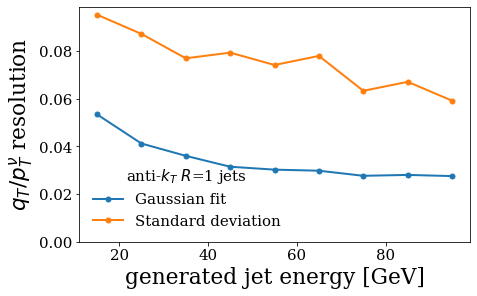

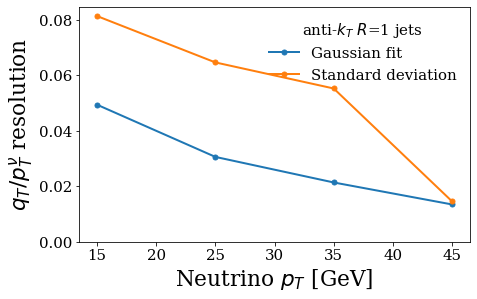

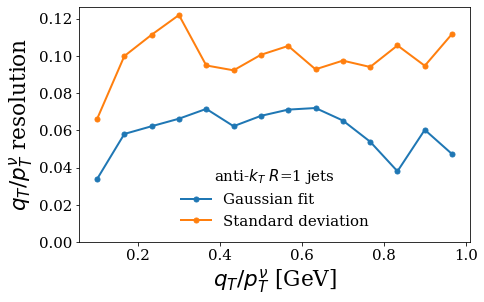

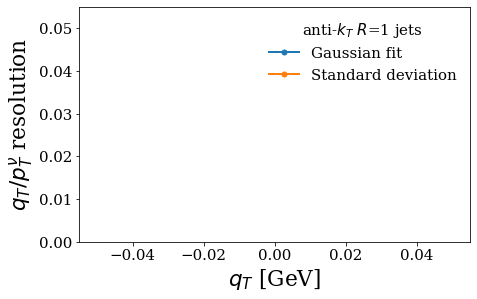

In [55]:
#corresponds to fig 10 of NC-DIS paper
expr = "qT/MissingET_MET-Gen_qT/GenMissingET_MET"

#a = df_rg.eval(expr)
#plt.hist(a[(a>a.quantile(.01))&(a<a.quantile(.99))],bins=100)
resolution_plot2(expr, "$q_T/p^{\\nu}_{T}$ resolution",condition="MissingET_MET>5 and Neutrino_PT>5",nbins=10,xrange=(0,100))
plt.savefig("images/jetE_vs_qtoverptnu_resolution_for_paper.png")
plt.show()

resolution_plot2(expr, "$q_T/p^{\\nu}_{T}$ resolution",xlbl="Neutrino $p_T$ [GeV]", xexpr="Neutrino_PT",condition="MissingET_MET>10 and Neutrino_PT>10",nbins=10,xrange=(0,100))
plt.savefig("images/nuPT_vs_qtoverptnu_resolution_for_paper.png")
plt.show()

resolution_plot2(expr, "$q_T/p^{\\nu}_{T}$ resolution",xlbl="$q_T/p^\\nu_T$ [GeV]", xexpr="Gen_qT/Neutrino_PT",condition="MissingET_MET>10 and Neutrino_PT>10",nbins=15,xrange=(0,1))
plt.savefig("images/qtovernuPT_vs_qtoverptnu_resolution_for_paper.png")
plt.show()

resolution_plot2(expr, "$q_T/p^{\\nu}_{T}$ resolution",xlbl="$q_T$ [GeV]", xexpr="qT",condition="MissingET_MET>20 and Neutrino_PT>20 and Neutrino_PT==GenMissingET_MET",nbins=15,xrange=(0,100))
plt.savefig("images/qt_vs_qtoverptnu_resolution_for_paper.png")
plt.show()

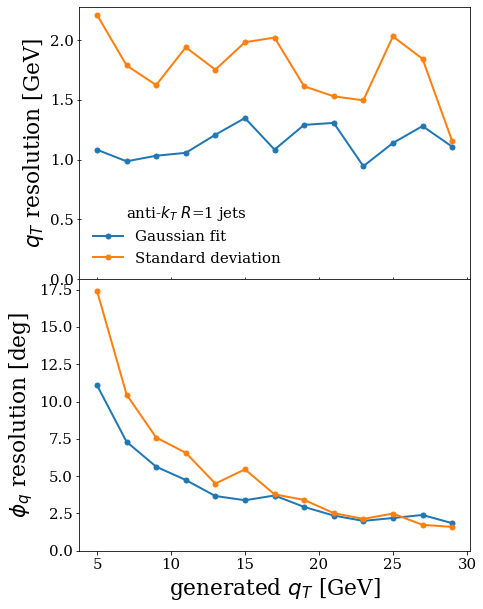

In [56]:
#alternative version of fig 10 of NC-DIS paper


fig,axs = plt.subplots(2,1,figsize=(7,10),sharex='all')
fig.subplots_adjust(hspace=0)
plt.sca(axs[0])
axs[0].tick_params(bottom=True,direction='inout')
resolution_plot2("(qT-Gen_qT)", "$q_T$ resolution [GeV]",xlbl="generated $q_T$ [GeV]", xexpr="Gen_qT",condition="MissingET_MET>5 and Neutrino_PT>5",nbins=14,xrange=(2,30),axs=axs[0])
plt.sca(axs[1])
resolution_plot2("((qT_Phi-Gen_qT_Phi)+2*3.14159*(qT_Phi-Gen_qT_Phi<-3.14159)-2*3.14159*(qT_Phi-Gen_qT_Phi>3.14159))*180/3.14159", "$\\phi_q$ resolution [deg]",xlbl="generated $q_T$ [GeV]", 
                 xexpr="Gen_qT",condition="MissingET_MET>5 and Neutrino_PT>5",nbins=14,xrange=(2,30),axs=axs[0],makeLegend=False)
plt.savefig("images/qt_vs_qt_and_phi_q_resolution_for_paper.png")
plt.show()

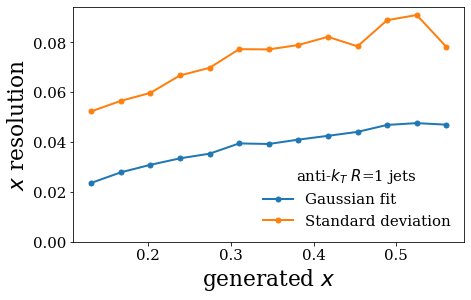

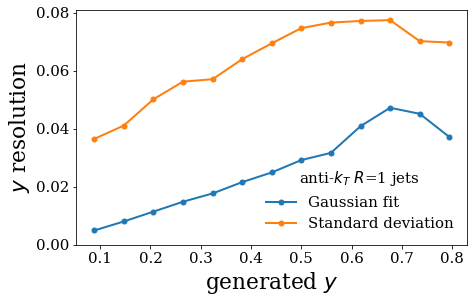

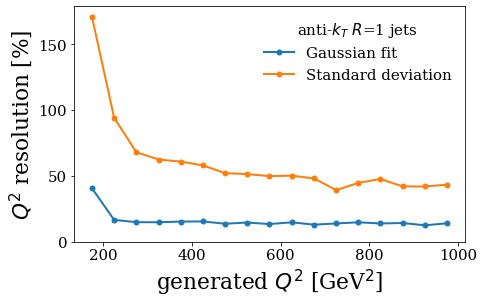

In [57]:
#fig,axs = plt.subplots(2,1,figsize=(7,10),sharex='all')
#fig.subplots_adjust(hspace=0)
#plt.sca(axs[0])
#axs[0].tick_params(bottom=True,direction='inout')

query="MissingET_MET>15 and Gen_y>0 and JB_y<0.85 and Gen_Q2>100"
resolution_plot2("(JB_x-Gen_x)", "$x$ resolution",xlbl="generated $x$", 
                 xexpr="Gen_x",condition=query,
                 nbins=14,
                    include_gauss=True,df=df_nu)
plt.savefig("images/x_resolution_for_paper.png")
plt.show()

resolution_plot2("(JB_y-Gen_y)", "$y$ resolution",xlbl="generated $y$", 
                 xexpr="Gen_y",condition=query,
                 nbins=14,
                    include_gauss=True,df=df_nu)
plt.savefig("images/y_resolution_for_paper.png")
plt.show()

resolution_plot2("100*(JB_Q2-Gen_Q2)/Gen_Q2", "$Q^2$ resolution [%]",xlbl="generated $Q^2$ [GeV$^2$]", 
                 xexpr="Gen_Q2",condition=query,
                 nbins=18,xrange=(100,1000),
                    include_gauss=True,df=df_nu)
plt.savefig("images/Q2_resolution_for_paper.png")
plt.show()


In [177]:
print(len(df_nu.query('JB_y<0'))/len(df_nu))

0.0


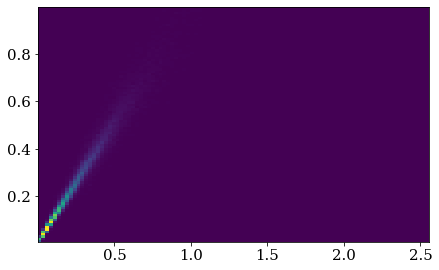

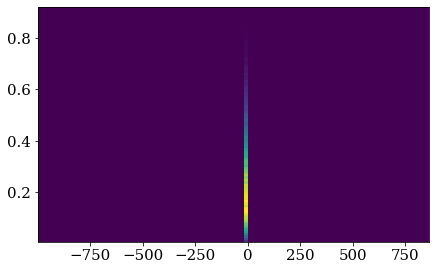

In [178]:
df = df_nu.query(f'JB_y>{min(df_nu.JB_y)}')
plt.hist2d(df.JB_y,
           df.Gen_y,bins=100)
plt.show()
df = df_nu.query('JB_y<1')
plt.hist2d(df.JB_x,
           df.Gen_x,bins=100)
plt.show()

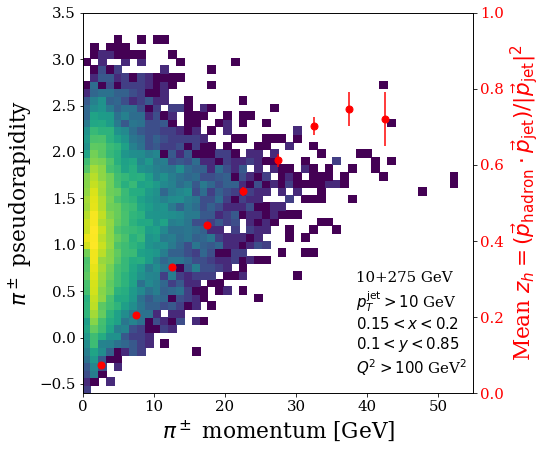

In [32]:
# Corresponds to fig11 of NC-DIS paper
import matplotlib as mpl
jetptmin = 10
q2min = 100
xmin,xmax = .15,.20
ymin,ymax = .1,.85
fig,ax = plt.subplots(1,1,figsize=(7,7),sharex='all')
df = df_hadrons.query(f"Gen_Q2>{q2min} and Jet_PT>{jetptmin} and Gen_x>{xmin} and Gen_x<{xmax} and Gen_y>{ymin} and Gen_y<{ymax} and abs(Hadron_PID)==211")

plt.sca(ax)
plt.hist2d(df.Hadron_P,df.Hadron_Eta, 
               bins=50, norm=mpl.colors.LogNorm(),range=((0,55),(-.6,3.5)))
plt.text(0.7,0.05,"10+275 GeV\n$p_T^{\\mathrm{jet}}>"+str(jetptmin)+\
         "$ GeV\n$"+str(xmin)+"<x<" + str(xmax) + "$\n$" + str(ymin) + "<y<"+str(ymax)+"$\n$Q^2>" + str(q2min)+"$ GeV$^2$",
         transform=plt.gca().transAxes)

plt.gca().set_xlabel("$\\pi^\\pm$ momentum [GeV]")
plt.gca().set_ylabel("$\\pi^\\pm$ pseudorapidity")

ax2 = ax.twinx()
plt.sca(ax2)
ax2.set_ylim(0,1)

ax2.set_ylabel(\
    "Mean $z_h = (\\vec p_{\\mathrm{hadron}}\\cdot\\vec p_{\\mathrm{jet}})/|\\vec p_{\\mathrm{jet}}|^2$",
               color='r')
ax2.tick_params(labelcolor='r')

partitions = np.arange(0,50,5)
x = []
y = []
dy = []
for i in range(len(partitions[:-1])):
    dfs = df.query(f"Hadron_P>{partitions[i]} and  Hadron_P<{partitions[i+1]}")
    x.append((partitions[i]+partitions[i+1])/2)
    y.append(np.mean(dfs.Hadron_Zh))
    dy.append(np.std(dfs.Hadron_Zh)/np.sqrt(len(dfs)))
    del dfs
plt.errorbar(x,y,dy,color='r',marker='o',linestyle ='',markersize=7)
plt.savefig("images/hadron_momentum_pseudorapidity_and_zh.png",bbox_inches='tight')
plt.show()

<ipython-input-25-63f2ed513fec>:13: RuntimeWarning: invalid value encountered in true_divide
  axs[1].errorbar(x,r/g,drat, color='g',marker='o', label='gen.')


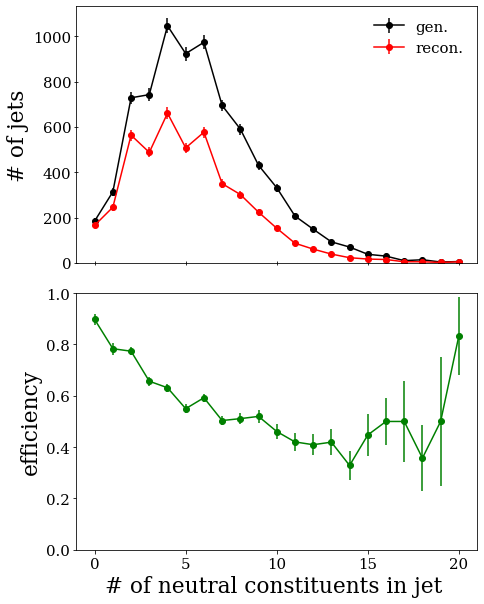

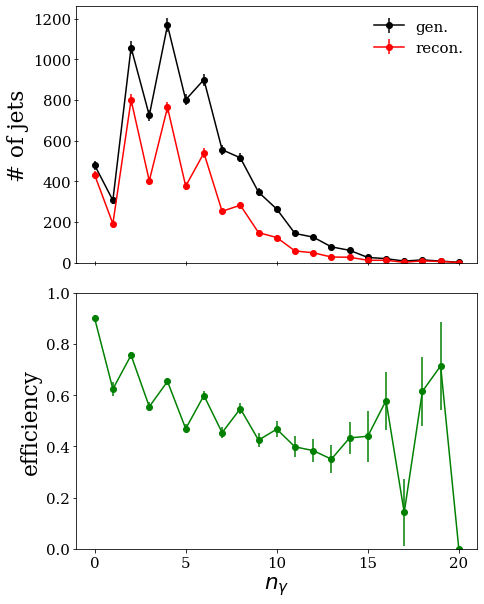

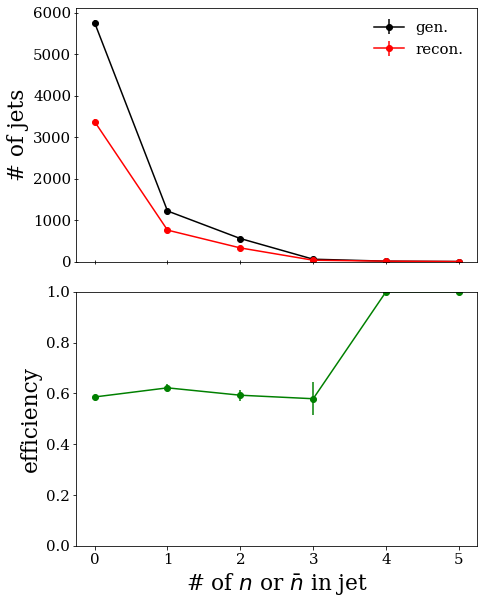

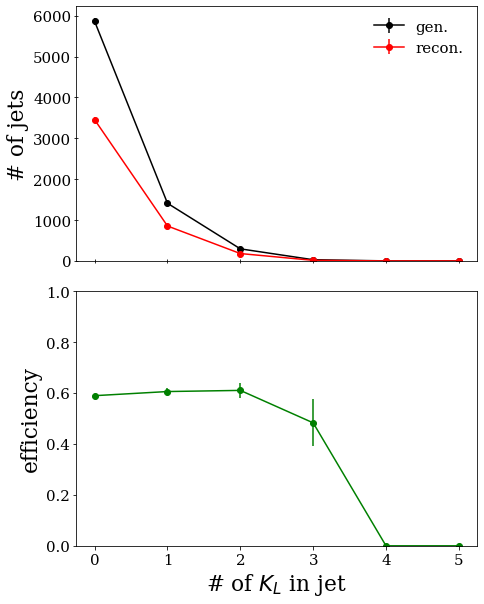

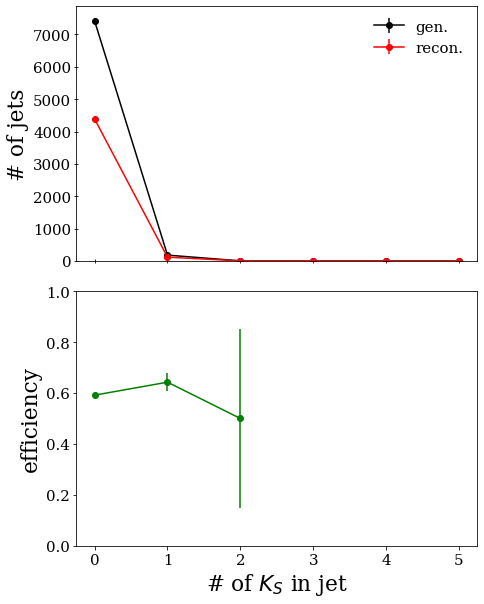

In [25]:
def efficiency_vs(xvar,xlabel,bins = dict(bins=np.linspace(-0.5,20.5,22))):
    df = df_jets.query('GenJet_PT>10')
    fig,axs = plt.subplots(2,1, figsize=(7,14/golden),sharex='all')
    r,x = np.histogram(df.query('Jet_PT>0').eval(xvar),**bins)
    g,x = np.histogram(df.eval(xvar),**bins)
    x = (x[:-1]+x[1:])/2
    axs[0].errorbar(x,g,np.sqrt(g), color='k',marker='o', label='gen.')
    axs[0].errorbar(x,r,np.sqrt(r), color='r',marker='o', label='recon.')
    axs[0].legend(framealpha=0)
    axs[0].set_ylabel('# of jets')
    axs[0].set_ylim(0)
    drat = np.sqrt(r*(g-r))/(g**(3/2)+.01)
    axs[1].errorbar(x,r/g,drat, color='g',marker='o', label='gen.')
    axs[1].set_ylabel('efficiency')
    axs[1].set_ylim(0, 1)
    #axs[0].set_xlabel('# of neutral hadrons in jet ')
    axs[1].set_xlabel(xlabel)
    fig.tight_layout()
    axs[0].tick_params(bottom=True,direction='inout')

efficiency_vs("GenJet_NNeutrals","# of neutral constituents in jet ")
plt.savefig('images/efficiency_vs_nneutral.png')
efficiency_vs("GenJet_n_22","$n_{\\gamma}$")
plt.savefig('images/efficiency_vs_ngamma.png')
efficiency_vs("GenJet_n_2112+GenJet_n_m2112",
              "# of $n$ or $\\bar n$ in jet ",
             bins = dict(bins=np.linspace(-0.5,5.5,7)))
plt.savefig('images/efficiency_vs_n_nbar.png')
efficiency_vs("GenJet_n_130",
              "# of $K_L$ in jet ",
             bins = dict(bins=np.linspace(-0.5,5.5,7)))
plt.savefig('images/efficiency_vs_KL.png')
efficiency_vs("GenJet_n_310",
              "# of $K_S$ in jet ",
             bins = dict(bins=np.linspace(-0.5,5.5,7)))
plt.savefig('images/efficiency_vs_KS.png')

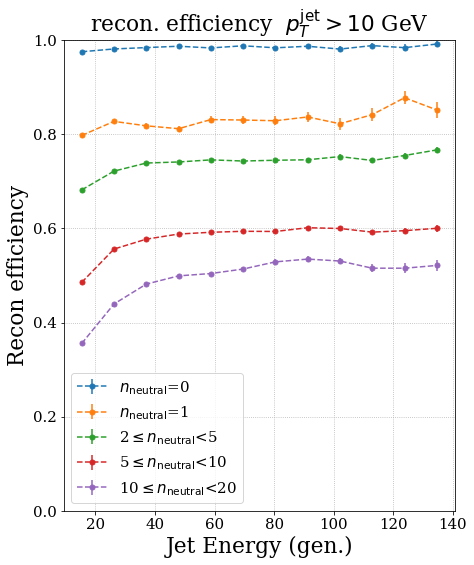

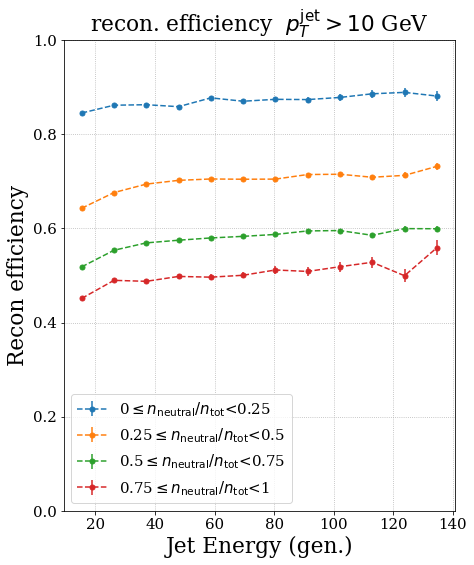

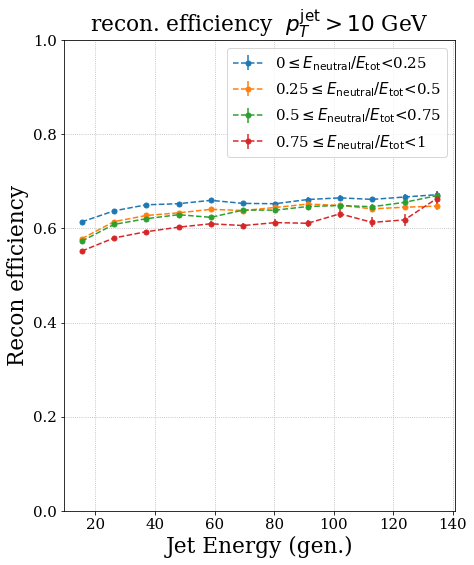

In [22]:

def efficiency_plot(xvar = 'GenJet_NNeutrals',
            xlbl = '$n_{\\mathrm{neutral}}$',
        partitions = [0,1,2,4, 20]):
    df = df_jets
    fig,axs = plt.subplots(1,1, figsize=(7,14/golden),sharex='all')
    for j in range(len(partitions)-1):
        x,y,dy = [],[],[]
        lbl = f'{partitions[j]}$\leq${xlbl}<{partitions[j+1]}'
        dfj = df.query(f"GenJet_PT>10 and {xvar} >= {partitions[j]} and {xvar} < {partitions[j+1]}")
        v = dfj.eval(xvar)[:1000]
        if np.std(v) == 0:
            mean = np.mean(v)
            if mean%1 == 0:
                mean = str(int(mean))
            lbl = f"{xlbl}={mean}"
        E = np.linspace(10, 140,(140-15)//10+1)
        for i in range(len(E)-1):

            df_slice = dfj.query(f"GenJet_E>{E[i]} and GenJet_E<{E[i+1]}")

            n = len(df_slice.query("Jet_PT>0")) #numerator: count gen jets that have a recon jet
            d = len(df_slice) #denominator:  count just the gen jets.  
            if(n>5):
                x.append((E[i]+E[i+1])/2)
                y.append(n/d)
                dy.append(np.sqrt(n*(d-n))/max(d**(3/2),1))
            del df_slice
        plt.errorbar(x,y,dy,linestyle='--',marker='o',markersize=5, label=lbl)

    plt.gca().legend(ncol=1)
    plt.gca().set_ylabel("Recon efficiency")
    plt.gca().set_xlabel("Jet Energy (gen.)")
    plt.grid(linestyle=':')
    plt.gca().set_title("recon. efficiency  $p^{\\mathrm{jet}}_T>10$ GeV")
    plt.gca().set_ylim(0,1)

efficiency_plot(xvar = 'GenJet_NNeutrals',
            xlbl = '$n_{\\mathrm{neutral}}$',
        partitions = [0,1,2,5,10,20])
plt.savefig("images/Egen_vs_efficiency_nneutral.png",bbox_inches='tight')
plt.show()

efficiency_plot(xvar = 'GenJet_NNeutrals/(GenJet_NNeutrals+GenJet_NCharged)',
            xlbl = '$n_{\\mathrm{neutral}}/n_{\\mathrm{tot}}$',
        partitions = [0,0.25,0.5,0.75, 1])
plt.savefig("images/Egen_vs_efficiency_nneutral_frac.png",bbox_inches='tight')
plt.show()

efficiency_plot(xvar = 'GenJet_NeutralEnergyFraction',
            xlbl = '$E_{\\mathrm{neutral}}/E_{\\mathrm{tot}}$',
        partitions = [0,0.25,0.5,0.75, 1])
plt.savefig("images/Egen_vs_efficiency_Eneutral_frac.png",bbox_inches='tight')
plt.show()

# now for diagnostic plots

(array([295616., 427417., 374811., 321895., 274866., 239191., 207089.,
        182482., 162385., 144469., 129574., 117381., 106205.,  95661.,
         87249.,  79468.,  73722.,  67428.,  62133.,  57279.,  52981.,
         49170.,  45850.,  42532.,  39895.,  37641.,  35181.,  32851.,
         30630.,  29455.,  27560.,  25782.,  24477.,  23193.,  21555.,
         20850.,  19831.,  18952.,  17733.,  16986.,  15945.,  15404.,
         14683.,  14054.,  13423.,  12717.,  12300.,  11715.,  11370.,
         10699.,  10440.,   9648.,   9481.,   9106.,   8708.,   8519.,
          8201.,   7835.,   7638.,   7187.,   7062.,   6795.,   6403.,
          6360.,   6219.,   5818.,   5764.,   5517.,   5302.,   5296.,
          4969.,   4812.,   4798.,   4578.,   4446.,   4370.,   4219.,
          3901.,   3914.,   3854.,   3771.,   3490.,   3447.,   3339.,
          3316.,   3129.,   3085.,   3059.,   2871.,   2912.,   2785.,
          2704.,   2662.,   2650.,   2458.,   2472.,   2446.,   2262.,
      

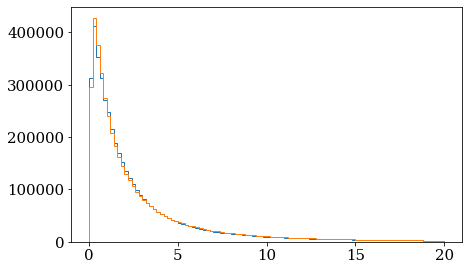

In [16]:
plt.hist(df_hadrons.query('Hadron_Charge==0').Hadron_E,histtype='step',bins=100, range=(0,20))
plt.hist(df_hadrons.query('Hadron_Charge==0').GenHadron_E,histtype='step',bins=100, range=(0,20))

In [ ]:
neuts = df_hadrons.query('Hadron_Charge==0')
plt.hist(neuts.eval('GenHadron_E-Hadron_E'),histtype='step',bins=100,range=(-10,10))
plt.show()
plt.hist(neuts.eval('Hadron_E'),histtype='step',bins=100, range=(0,1))
plt.hist(neuts.eval('GenHadron_E'),histtype='step',bins=100, range=(0,1))
plt.show()

In [27]:
print(set(neuts.eval('GenHadron_PID')))
print(len(neuts.query('GenHadron_PID ==22'))/len(neuts))

{130, -3322, 11, 13, -3312, 22, 3222, 2212, 3112, -211, 3122, 310, -321, 2112, -2112, 321, -3122, 211, -3112, -2212, -3222, 3312, -13, -11, 3322}
0.7559152235854334


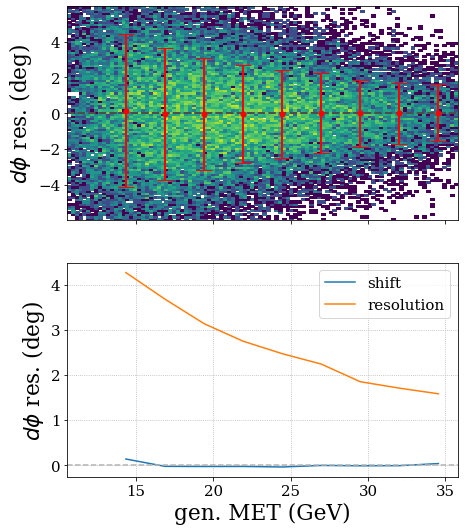

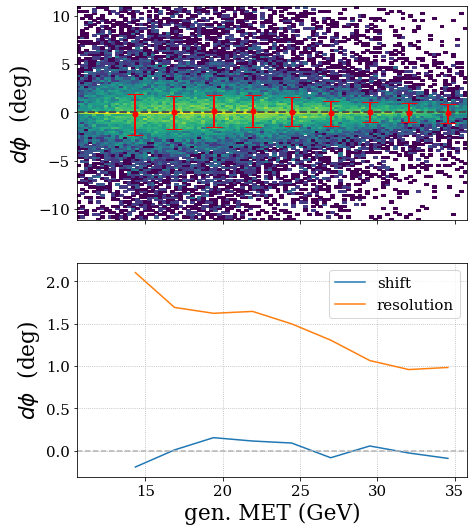

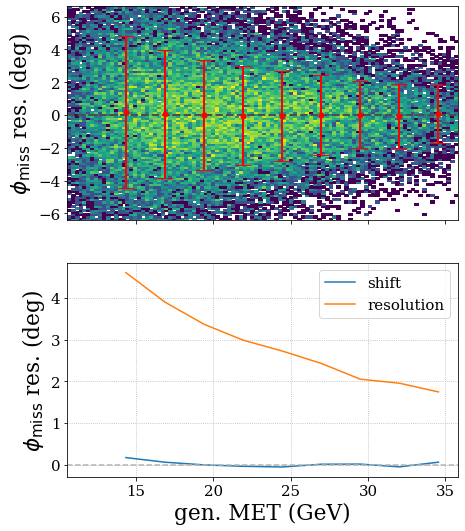

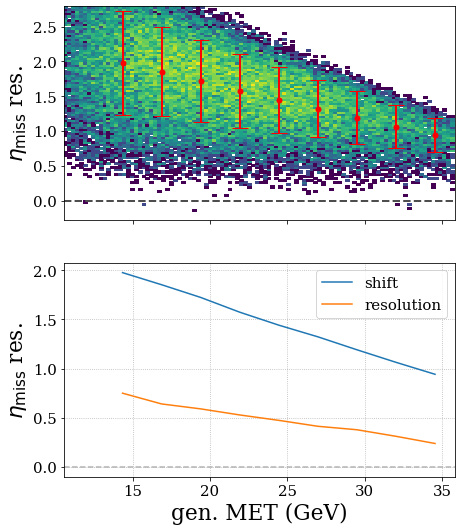

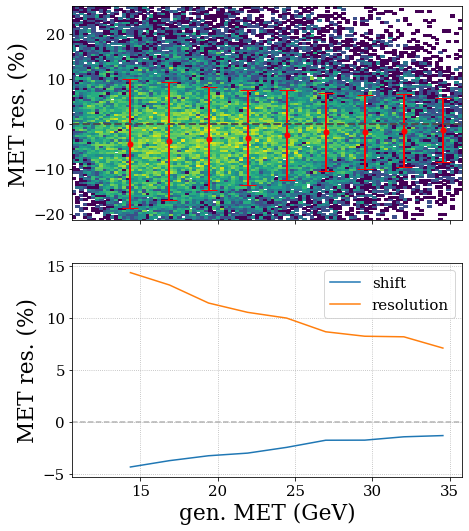

In [264]:
def resolution_plot(yexpr, ylbl,xlbl="gen. MET (GeV)", xexpr="GenMissingET_MET", condition = None):
    df = df_jets.query("Jet_PT>10 and GenJet_PT>10")
    if condition != None:
        df = df.query(condition)
    fig,axs = plt.subplots(2,1, figsize=(7,14/golden),sharex='all')
    plt.sca(axs[0])

    import matplotlib as mpl
    xv = df.eval(xexpr)
    yv = df.eval(yexpr)
    
    mn,mx = xv.quantile(.03),xv.quantile(.97)
    if mn > 0 and mn < mx*.12:
        mn = 0
    
    ymn = yv.quantile(.05)
    ymx = yv.quantile(.95)
    
    if(ymn>-.1*ymx):
        ymn = -.1*ymx
    
    plt.hist2d(xv,yv, 
               bins=100,range=([mn,mx],[ymn,ymx]), norm=mpl.colors.LogNorm())
    plt.gca().set_ylabel(ylbl)

    plt.axhline(0,linestyle='--',color='0.3',linewidth=2)
    x,y,dy = [],[],[]
    
    nbins = 10
    
    for i in range(1,nbins):
        
        df_slice = df_rg.query("%s>%s and %s<%s" \
                               %(xexpr,i*(mx-mn)/nbins+mn,xexpr,(i+1)*(mx-mn)/nbins+mn))
        if len(df_slice)<3:
            continue
        x.append((i+0.5)*(mx-mn)/nbins+mn)
        mean,std = misc_util.getmeanstd(df_slice,yexpr)
        y.append(mean)
        dy.append(std)
        del df_slice
    plt.errorbar(x,y,dy, color='r',linestyle='',marker='o',markersize=5,linewidth=2,capsize=8)
    gc.collect()

    plt.sca(axs[1])

    plt.plot(x,y,label='shift')
    plt.plot(x,dy,label='resolution')
    plt.axhline(0,linestyle='--',color='0.7')
    plt.legend()
    plt.gca().set_ylabel(ylbl)

    plt.gca().set_xlabel(xlbl)
    plt.grid(linestyle=':')
    del df
phistr = lambda expr : "(XXX - 2*3.141592653589793*(XXX>3.141592653589793) + 2*3.141592653589793*(XXX<-3.141592653589793))*180/3.141592653589793".replace("XXX",expr)


resolution_plot(phistr("MissingET_Phi-GenMissingET_Phi-Jet_Phi+GenJet_Phi"), "$d\\phi$ res. (deg)")
plt.savefig("images/MET_vs_dphi_resolution.png")


resolution_plot(phistr("MissingET_Phi-Jet_Phi+3.141592653589793"), "$d\\phi$  (deg)")
plt.savefig("images/MET_vs_dphi_recon.png")


resolution_plot(phistr("MissingET_Phi-GenMissingET_Phi"), "$\\phi_{\\mathrm{miss}}$ res. (deg)")
plt.savefig("images/MET_vs_ETphi_resolution.png")

resolution_plot("MissingET_Eta-GenMissingET_Eta", "$\\eta_{\\mathrm{miss}}$ res.")
plt.savefig("images/MET_vs_ETeta_resolution.png")

resolution_plot("(MissingET_MET-GenMissingET_MET)*100/GenMissingET_MET", "MET res. (%)")
plt.savefig("images/MET_vs_MET_resolution.png")

#resolution_plot(phistr("Jet_Phi-GenJet_Phi"), "$\\phi_{\\mathrm{jet}}$ res. (deg)","gen. $E_{\\mathrm{jet}}$ (GeV)", "GenJet_E")
#plt.savefig("images/Ejet_vs_jetphi_resolution.png")

#resolution_plot("Jet_Eta-GenJet_Eta", "$\\eta_{\\mathrm{jet}}$ res.","gen. $E_{\\mathrm{jet}}$ (GeV)", "GenJet_E")
#plt.savefig("images/Ejet_vs_jeteta_resolution.png")

#resolution_plot("(Jet_E-GenJet_E)*100/GenJet_E", "$E_{\\mathrm{jet}}$ res. (%)","gen. $E_{\\mathrm{jet}}$ (GeV)", "GenJet_E")
#plt.savefig("images/Ejet_vs_jetE_resolution.png")

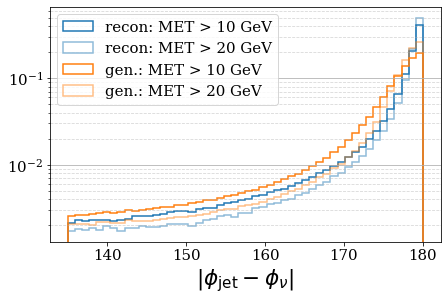

In [52]:
df = df_jets.query("Jet_PT>0")
args = dict(bins =50,histtype='step',density=True,range=(135,180),linewidth=1.5)
expr = "abs(" + phistr("MissingET_Phi-Jet_Phi")+")"
plt.hist(df.query("MissingET_MET>10").eval(expr),**args,label='recon: MET > 10 GeV',color='tab:blue')
plt.hist(df.query("MissingET_MET>20").eval(expr),**args,label='recon: MET > 20 GeV',color='tab:blue',alpha=0.5)

df = df_jets.query("GenJet_PT>0")

expr = "abs(" + phistr("GenMissingET_Phi-GenJet_Phi")+")"
plt.hist(df.query("GenMissingET_MET>10").eval(expr),**args,label='gen.: MET > 10 GeV',color='tab:orange')
plt.hist(df.query("GenMissingET_MET>20").eval(expr),**args,label='gen.: MET > 20 GeV',color='tab:orange',alpha=0.5)
plt.legend(loc='upper left')

plt.gca().set_xlabel("$|\\phi_{\\mathrm{jet}}-\\phi_{\\nu}|$")
plt.gca().set_yscale('log')
plt.savefig("images/deltaphi.png")
plt.grid(which='major',axis='y')
plt.grid(b=True,which='minor',linestyle='--',alpha=0.5,axis='y')
plt.savefig("images/deltaphi.png")
plt.show()


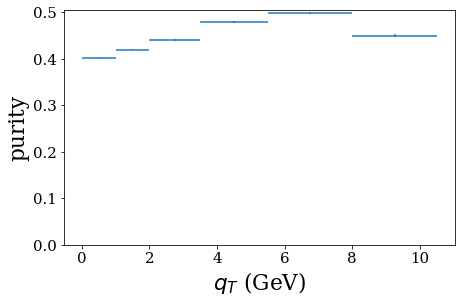

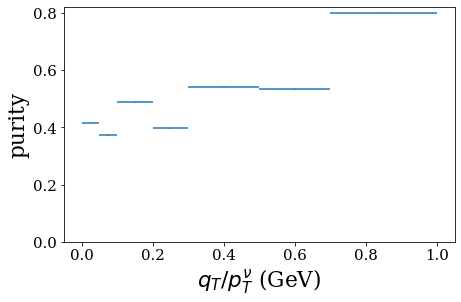

In [49]:
def purity_plot(df, expr,genExpr,partitions):
    xs = []
    ys = []
    dys = []
    dxs = []
    for i in range(len(partitions)-1):
        x=(partitions[i]+partitions[i+1])/2
        dx = (partitions[i+1]-partitions[i])/2
        num = len(df.query(f"{expr}>={partitions[i]} and {expr}<{partitions[i+1]} and {genExpr}>={partitions[i]} and {genExpr}<{partitions[i+1]}"))
        denom = len(df.query(f"{expr}>={partitions[i]} and {expr}<{partitions[i+1]}"))
        if denom == 0:
            continue
        y =num/denom
        dy = np.sqrt(((denom-num)*num)/denom**3)
        
        xs.append(x)
        ys.append(y)
        dys.append(dy)
        dxs.append(dx)
    plt.errorbar(xs,ys,dys,dxs,linestyle='')
    
    
purity_plot(df_rg.query("Jet_PT>0"),"qT","Gen_qT",[0,1,2,3.5,5.5,8,10.5])
plt.gca().set_xlabel("$q_T$ (GeV)")
plt.gca().set_ylabel("purity")   
plt.gca().set_ylim(0)
plt.savefig("images/purity_qT.png")
plt.show()
purity_plot(df_rg.query("Jet_PT>0"),"qT/MissingET_MET","Gen_qT/GenMissingET_MET",[0,0.05,0.1,0.2,0.3,0.5,0.7,1])
plt.gca().set_xlabel("$q_T/p^\\nu_T$ (GeV)")
plt.gca().set_ylabel("purity")   
plt.gca().set_ylim(0)
plt.savefig("images/purity_qToverptnu.png")

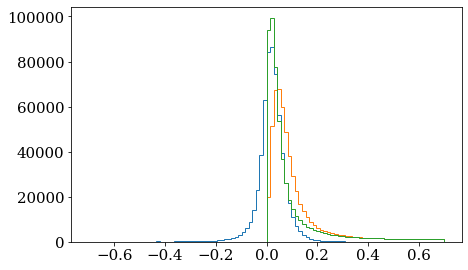

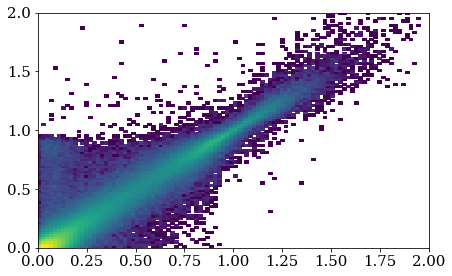

In [46]:
df = df_rg.query("Neutrino_PT>15")
expr1 = "sqrt(GenMissingET_MET**2+GenJet_PT**2+2*GenMissingET_MET*GenJet_PT*cos(GenJet_Phi-GenMissingET_Phi))/GenMissingET_MET"
expr2 = expr1.replace("Gen","")
plt.hist(df.eval(expr1+ "-("+expr2+")"), bins=100, range=(-.7,.7),histtype='step')
plt.hist(df.eval(expr1), bins=100, range=(-.7,.7),histtype='step')
plt.hist(df.eval(expr2), bins=100, range=(-.7,.7),histtype='step')
plt.show()
plt.hist2d(df.eval(expr1),df.eval(expr2),range=((0,2),(0,2)),bins=100,norm=mpl.colors.LogNorm())
plt.show()

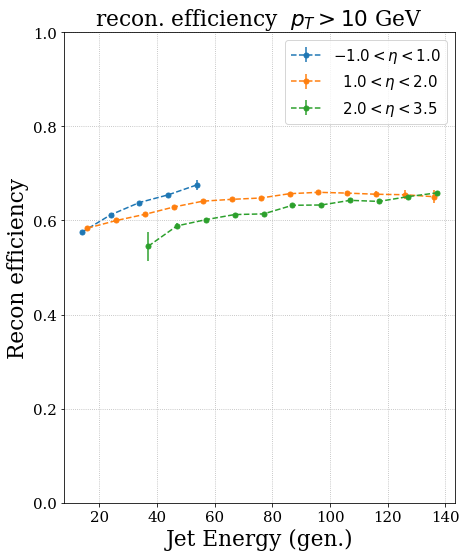

In [139]:
#etanumin,etanumax=-3.5,3.5

df = df_jets
fig,axs = plt.subplots(1,1, figsize=(7,14/golden),sharex='all')
for etarange,lbl in [(-1,1), "$-1.0<\\eta<1.0$"],[(1,2), "  $1.0<\\eta<2.0$"],[(2,3.5), "  $2.0<\\eta<3.5$"]  :
    x,y,dy = [],[],[]
    for i in range(1,14):
        
        df_slice = df.query("GenJet_E>%s and GenJet_E<%s and GenJet_Eta>%s and GenJet_Eta<%s and GenJet_PT>10" %(i*10,(i+1)*10,*etarange))
        
        n = len(df_slice.query("Jet_PT>0")) #numerator: count gen jets that have a recon jet
        d = len(df_slice) #denominator:  count just the gen jets.  
        if(n>5):
            x.append(i*10+5)
            y.append(n/d)
            dy.append(np.sqrt(n*(d-n))/max(d**(3/2),1))
        del df_slice
    plt.errorbar(np.add(x,etarange[0]),y,dy,linestyle='--',marker='o',markersize=5, label=lbl)

plt.gca().legend(ncol=1)
plt.gca().set_ylabel("Recon efficiency")
plt.gca().set_xlabel("Jet Energy (gen.)")
plt.grid(linestyle=':')
plt.gca().set_title("recon. efficiency  $p_T>10$ GeV")
plt.gca().set_ylim(0,1)

plt.savefig("images/Egen_vs_efficiency_eta.png",bbox_inches='tight')
plt.show()

In [140]:
print(list(df_jets.columns))

['Jet_PT', 'Jet_Eta', 'Jet_Phi', 'Jet_Mass', 'Jet_DeltaEta', 'Jet_DeltaPhi', 'Jet_Flavor', 'Jet_FlavorAlgo', 'Jet_FlavorPhys', 'Jet_BTag', 'Jet_BTagAlgo', 'Jet_BTagPhys', 'Jet_TauTag', 'Jet_TauWeight', 'Jet_Charge', 'Jet_EhadOverEem', 'Jet_NCharged', 'Jet_NNeutrals', 'Jet_NeutralEnergyFraction', 'Jet_ChargedEnergyFraction', 'Jet_NSubJetsTrimmed', 'Jet_NSubJetsPruned', 'Jet_NSubJetsSoftDropped', 'GenJet_PT', 'GenJet_Eta', 'GenJet_Phi', 'GenJet_Mass', 'GenJet_DeltaEta', 'GenJet_DeltaPhi', 'GenJet_Flavor', 'GenJet_FlavorAlgo', 'GenJet_FlavorPhys', 'GenJet_BTag', 'GenJet_BTagAlgo', 'GenJet_BTagPhys', 'GenJet_TauTag', 'GenJet_TauWeight', 'GenJet_Charge', 'GenJet_EhadOverEem', 'GenJet_NCharged', 'GenJet_NNeutrals', 'GenJet_NeutralEnergyFraction', 'GenJet_ChargedEnergyFraction', 'GenJet_NSubJetsTrimmed', 'GenJet_NSubJetsPruned', 'GenJet_NSubJetsSoftDropped', 'Neutrino_PID', 'Neutrino_Status', 'Neutrino_IsPU', 'Neutrino_M1', 'Neutrino_M2', 'Neutrino_D1', 'Neutrino_D2', 'Neutrino_Mass', 'Neutri

In [82]:
print(df_jets.columns)

Index(['Jet_PT', 'Jet_Eta', 'Jet_Phi', 'Jet_Mass', 'Jet_DeltaEta',
       'Jet_DeltaPhi', 'GenJet_PT', 'GenJet_Eta', 'GenJet_Phi', 'GenJet_Mass',
       'GenJet_DeltaEta', 'GenJet_DeltaPhi', 'Neutrino_PID', 'Neutrino_Status',
       'Neutrino_E', 'Neutrino_Px', 'Neutrino_Py', 'Neutrino_Pz',
       'Neutrino_PT', 'Neutrino_Eta', 'Quark_PID', 'Quark_Status', 'Quark_E',
       'Quark_Px', 'Quark_Py', 'Quark_Pz', 'Quark_PT', 'Quark_Eta',
       'MissingET_MET', 'MissingET_Eta', 'MissingET_Phi', 'GenMissingET_MET',
       'GenMissingET_Eta', 'GenMissingET_Phi', 'Event_Number', 'Gen_W2',
       'Gen_x', 'Gen_y', 'Gen_Q2', 'Hadron_PID', 'Hadron_Charge', 'Hadron_P',
       'Hadron_PT', 'Hadron_Eta', 'Hadron_Phi', 'GenHadron_PID',
       'GenHadron_Charge', 'GenHadron_P', 'GenHadron_PT', 'GenHadron_Eta',
       'GenHadron_Phi', 'Hadron_i', 'Jet_i', 'JB_MET', 'JB_Eta', 'JB_Phi',
       'JB_Q2', 'JB_x', 'JB_y', 'Jet_E', 'GenJet_E', 'Hadron_Px', 'Hadron_Py',
       'Hadron_Pz', 'GenHadron_Px', 'Ge

<ipython-input-54-348a23df6d48>:17: RuntimeWarning: invalid value encountered in true_divide
  pc = plt.pcolor(n/d)


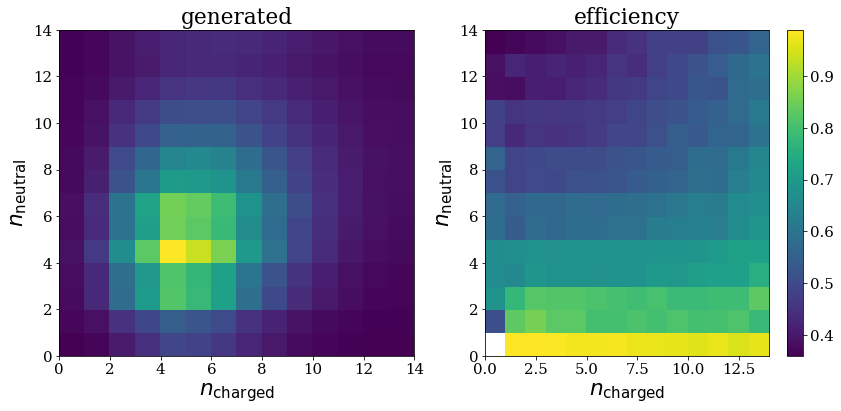

In [54]:
df = df_jets.query('GenJet_PT>10')
mx = 14
bins = mx
binning = dict(bins=mx,range=((0,mx),(0,mx)))
recon = df.query('Jet_PT>0')
n,x,y = np.histogram2d(recon.GenJet_NNeutrals,recon.GenJet_NCharged,**binning)
d,x,y = np.histogram2d(df.GenJet_NNeutrals,df.GenJet_NCharged,**binning)
fig,axs= plt.subplots(1,2,figsize=(14,6))

plt.sca(axs[0])
pc = plt.pcolor(d)
plt.gca().set_title('generated')
plt.gca().set_ylabel('$n_{\\mathrm{neutral}}$')
plt.gca().set_xlabel('$n_{\\mathrm{charged}}$')

plt.sca(axs[1])
pc = plt.pcolor(n/d)
plt.gca().set_title('efficiency')
plt.gca().set_ylabel('$n_{\\mathrm{neutral}}$')
plt.gca().set_xlabel('$n_{\\mathrm{charged}}$')

cbar = plt.colorbar(pc)
#help(cbar)
del recon
#np.histogram2d(df.GenJet_NNeutral,df.GenJet_NCharged,**binning)

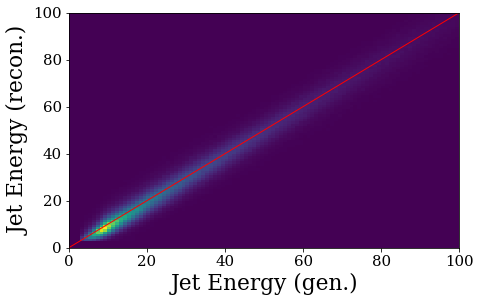

In [9]:

plt.hist2d(df_rg.GenJet_PT*np.cosh(df_rg.GenJet_Eta),df_rg.Jet_PT*np.cosh(df_rg.Jet_Eta), bins=100,range=([0,100],)*2)
plt.gca().set_xlabel("Jet Energy (gen.)")
plt.gca().set_ylabel("Jet Energy (recon.)")
plt.plot((0,100),(0,100),color='r',linewidth=1)
plt.savefig("images/Erecon_vs_Egen.png",bbox_inches='tight')
plt.show()

In [ ]:
fig,axs = plt.subplots(2,1, figsize=(7,14/golden),sharex='all')
plt.sca(axs[0])


df = df_jets.query("GenJet_Mass>0.05")
df_rg = df.query("Jet_PT*GenJet_PT>0")
import matplotlib as mpl
plt.hist2d(df_rg.eval("GenJet_E"),df_rg.eval("(Jet_E-GenJet_E)*100/GenJet_E"), 
           bins=100,range=([0,150],[-30,30]), norm=mpl.colors.LogNorm())
plt.gca().set_ylabel("jet energy res. (%)")

plt.axhline(0,linestyle='--',color='0.3',linewidth=2)
x,y,dy = [],[],[]
for i in range(1,14):
    df_slice = df_rg.query("GenJet_E>%s and GenJet_E<%s" %(i*10,(i+1)*10))
    x.append(i*10+5)
    q = df_slice.eval("(Jet_E-GenJet_E)*100/GenJet_E")
    y.append(np.mean(q))
    dy.append(np.std(q))
plt.errorbar(x,y,dy, color='r',linestyle='',marker='o',markersize=5)


plt.sca(axs[1])

plt.plot(x,y,label='jet energy scale')
plt.plot(x,dy,label='jet energy res.')
plt.axhline(0,linestyle='--',color='0.7')
plt.legend()
plt.gca().set_ylabel("jet energy res. (%)")

plt.gca().set_xlabel("Jet Energy (gen.)")
plt.grid(linestyle=':')

plt.savefig("images/Egen_vs_resolution.png")

In [177]:
10, 275

(array([ 2481.,  7039.,  9269., 10852., 11255., 11719., 11995., 12255.,
        12159., 12360., 12511., 12545., 12445., 12554., 12428., 12342.,
        12184., 12260., 12255., 12185., 12000., 12217., 11905., 11730.,
        11989., 11805., 11718., 11775., 11753., 11560., 11428., 11134.,
        11360., 11255., 11205., 10963., 11001., 10925., 10913., 10748.,
        10694., 10657., 10445., 10705., 10529., 10360., 10278., 10250.,
        10276., 10196., 10000., 10081.,  9869., 10165.,  9833.,  9828.,
         9612.,  9503.,  9442.,  9470.,  9304.,  9420.,  9401.,  9335.,
         9246.,  9208.,  9173.,  8964.,  9067.,  8960.,  8969.,  8853.,
         8837.,  8796.,  8746.,  8673.,  8787.,  8736.,  8653.,  8546.,
         8444.,  8579.,  8454.,  8532.,  8275.,  8254.,  8213.,  8294.,
         8205.,  8105.,  8111.,  8151.,  8163.,  8067.,  7930.,  7978.,
         7859.,  7996.,  8008.,  8038.]),
 array([0.00593436, 0.01587498, 0.0258156 , 0.03575622, 0.04569684,
        0.05563746, 0.0655

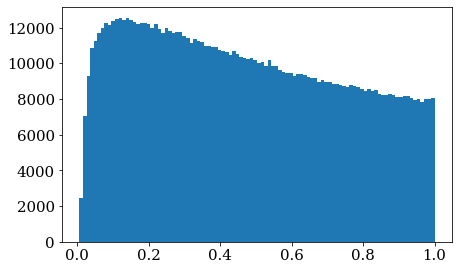

In [18]:
list(df_nu.columns)

['Jet_PT',
 'Jet_Eta',
 'Jet_Phi',
 'Jet_Mass',
 'Jet_DeltaEta',
 'Jet_DeltaPhi',
 'Jet_NCharged',
 'Jet_NNeutrals',
 'Jet_NeutralEnergyFraction',
 'Jet_ChargedEnergyFraction',
 'GenJet_PT',
 'GenJet_Eta',
 'GenJet_Phi',
 'GenJet_Mass',
 'GenJet_DeltaEta',
 'GenJet_DeltaPhi',
 'GenJet_NCharged',
 'GenJet_NNeutrals',
 'GenJet_NeutralEnergyFraction',
 'GenJet_ChargedEnergyFraction',
 'Neutrino_PID',
 'Neutrino_Status',
 'Neutrino_E',
 'Neutrino_Px',
 'Neutrino_Py',
 'Neutrino_Pz',
 'Neutrino_PT',
 'Neutrino_Eta',
 'Quark_PID',
 'Quark_Status',
 'Quark_E',
 'Quark_Px',
 'Quark_Py',
 'Quark_Pz',
 'Quark_PT',
 'Quark_Eta',
 'MissingET_MET',
 'MissingET_Eta',
 'MissingET_Phi',
 'GenMissingET_MET',
 'GenMissingET_Eta',
 'GenMissingET_Phi',
 'Event_Number',
 'Gen_W2',
 'Gen_x',
 'Gen_y',
 'Gen_Q2',
 'Hadron_PID',
 'Hadron_Charge',
 'Hadron_P',
 'Hadron_PT',
 'Hadron_Eta',
 'Hadron_Phi',
 'Hadron_E',
 'Hadron_ET',
 'Hadron_Eem',
 'Hadron_Ehad',
 'GenHadron_PID',
 'GenHadron_Charge',
 'GenHadron

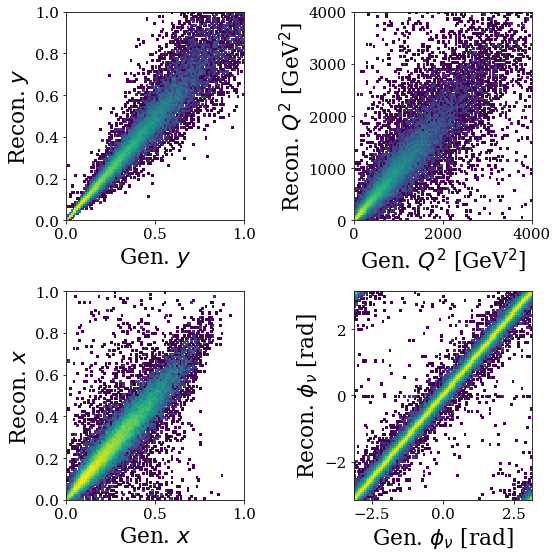

In [28]:
fig,axs = plt.subplots(2,2, figsize=(8,8))
plt.sca(axs[0][0])
plt.hist2d(df_nu.Gen_y,df_nu.JB_y,norm=mpl.colors.LogNorm(),bins=100, range=((0,1),(0,1)))
plt.gca().set_ylabel("Recon. $y$")
plt.gca().set_xlabel("Gen. $y$")
plt.sca(axs[0][1])
plt.hist2d(df_nu.Gen_Q2,df_nu.JB_Q2,norm=mpl.colors.LogNorm(),bins=100, range=((-1,4000),(-1,4000)))
plt.gca().set_ylabel("Recon. $Q^2$ [GeV$^2$]")
plt.gca().set_xlabel("Gen. $Q^2$ [GeV$^2$]")
plt.sca(axs[1][0])
plt.hist2d(df_nu.Gen_x,df_nu.JB_x,norm=mpl.colors.LogNorm(),bins=100, range=((0,1),(0,1)))
plt.gca().set_ylabel("Recon. $x$")
plt.gca().set_xlabel("Gen. $x$")
plt.sca(axs[1][1])
plt.hist2d(df_nu.GenMissingET_Phi-np.pi*(df_nu.GenMissingET_Phi>0)+np.pi*(df_nu.GenMissingET_Phi<0),df_nu.JB_Phi,norm=mpl.colors.LogNorm(),bins=100, range=((-np.pi,np.pi),(-np.pi,np.pi)))
plt.gca().set_ylabel("Recon. $\\phi_\\nu$ [rad]")
plt.gca().set_xlabel("Gen. $\\phi_\\nu$ [rad]")
plt.tight_layout()
plt.savefig("images/lepton_recon.png")
plt.show()


In [18]:
print([x for x in df_nu.columns if 'JB' in x])

['JB_MET', 'JB_Eta', 'JB_Phi', 'JB_Q2', 'JB_x', 'JB_y']


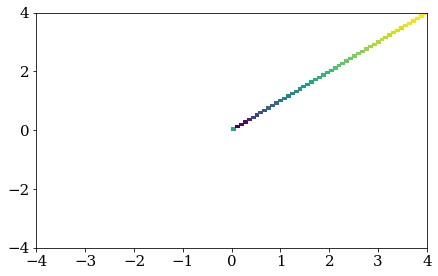

In [27]:
plt.hist2d(df_nu.MissingET_MET,df_nu.JB_MET,norm=mpl.colors.LogNorm(),bins=100, range=((-4,4),(-4,4)))
plt.show()

In [15]:
import ROOT
import collections
pdg = ROOT.TDatabasePDG()
l = list(set(df_hadrons.eval('GenHadron_PID')))
l.sort()
tot = len(df_hadrons)
for x in l:
    print(x,pdg.GetParticle(x).GetName(), 
          len(df_hadrons.query(f'GenHadron_PID=={x}'))/tot,sep='\t')

-3334	Omega+	1.179547542076525e-07
-3322	Xi0_bar	4.588439938677682e-05
-3312	Xi-_bar	2.5242317400437635e-05
-3222	Sigma+_bar	2.5124362646229983e-05
-3122	Lambda0_bar	0.0005586337159274422
-3112	Sigma-_bar	8.26862826995644e-05
-2212	antiproton	0.015986879656779973
-2112	antineutron	0.013060658114396531
-321	K-	0.02876586181812863
-211	pi-	0.22861848914822158
-13	mu+	6.180829120480991e-05
-11	e+	0.0017414839911217815
11	e-	0.0018832656056793798
13	mu-	0.00027801935566743697
22	gamma	0.42721454448174045
130	K_L0	0.02488680177125577
211	pi+	0.18601889375661948
310	K_S0	0.0020171442517050654
321	K+	0.028971221045204155
2112	neutron	0.01957164259190474
2212	proton	0.018878186591917954
3112	Sigma-	0.00023991997005836518
3122	Lambda0	0.0009237036802001268
3222	Sigma+	3.5150516753880443e-05
3312	Xi-	3.77455213464488e-05
3322	Xi0	7.089080727879915e-05


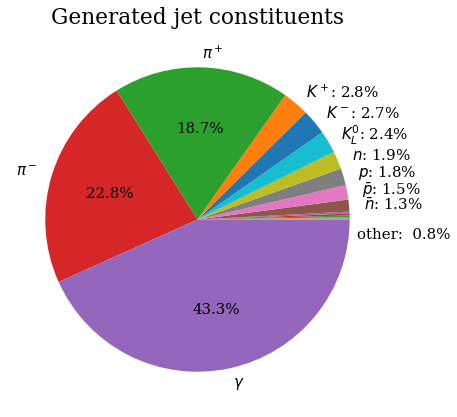

In [217]:

df = df_hadrons.query('GenJet_PT>10 and Gen_Q2>100')
l = list(set(df_hadrons.eval('GenHadron_PID')))
tot = len(df)
results = []
for x in l:
    results.append({'pid':x,'name':pdg.GetParticle(x).GetName(), 'frac':
          len(df.query(f'GenHadron_PID=={x}'))/tot})
#print(results)    
results.sort(key=lambda a: a['frac'])

fig,axs = plt.subplots(1,1,figsize=(7,7))

fracs = [r['frac'] for r in results]

latex_names = {211:'$\\pi^+$',-211:'$\\pi^-$',-2112:'$\\bar n$',2112:'$n$',
              321:'$K^+$',-321:'$K^-$',-2212:'$\\bar p$',2212:'$p$',
              22:'$\\gamma$',130:'$K^0_L$', 310:'$K^0_S$', 11: '$e^-$', -11: '$e^+$',
              3122:'$\\Lambda_0$',-3122:'$\\bar\\Lambda_0$',13:'$\\mu^-$',
               -3112:'$\\bar\\Sigma$', 3322:'$\\Xi_0$',-13:'$\\mu^+$', -3322:'$\\bar\\Xi_0$',
              3322:'$\\Xi^-$',-3322:'$\\bar\\Xi^-$',3222:'$\\Sigma^+$',-3222:'$\\bar\\Sigma^+$'}



common_types=[211,-211,-2112,2112,321,-321,-2212,2212,22,130]

labels = []

tot_others = 0

for r in results:
    if r['pid'] not in common_types:
        labels.append('')
        tot_others+= r['frac']
    elif r['frac']>.05:
        labels.append(latex_names[r['pid']])
    else :
        labels.append(f"{latex_names[r['pid']]}: {r['frac']*100:.1f}%")
#names = [r['name'] for r in results]
autopct = lambda x: ('%.1f%%'%x if x>5 else '')
plt.pie(fracs, labels=labels,autopct=autopct)


txt = f'other:  {tot_others*100:.1f}%'
# results.sort(key=lambda a: -a['frac'])
# for r in results:
#     if r['pid'] not in common_types:
#         print(f"\n{r['name']} {r['pid']}:  {r['frac']*100:.2f}")

plt.text(0.92,0.45, txt, transform=axs.transAxes)

#txt = ''
#for r in results:
#    if r['pid'] not in latex_names.keys():
#        txt+=f"{r['name']} {r['frac']*100:.2f}%\n"
#plt.text(0.8,0.2, txt, transform=axs.transAxes)
axs.set_title("Generated jet constituents")
plt.savefig("images/constituents.png")
plt.show()

Help on TParticlePDG in module __main__ object:

class TParticlePDG(TNamed)
 |  cppyy object proxy (internal)
 |  
 |  Method resolution order:
 |      TParticlePDG
 |      TNamed
 |      TObject
 |      CPPInstance
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  AddDecayChannel(...)
 |      int TParticlePDG::AddDecayChannel(int Type, double BranchingRatio, int NDaughters, int* DaughterPdgCode)
 |  
 |  AntiParticle(...)
 |      TParticlePDG* TParticlePDG::AntiParticle()
 |      const TParticlePDG* TParticlePDG::AntiParticle()
 |  
 |  Beauty(...)
 |      int TParticlePDG::Beauty()
 |  
 |  Charge(...)
 |      double TParticlePDG::Charge()
 |  
 |  Charm(...)
 |      int TParticlePDG::Charm()
 |  
 |  Class(...)
 |      static TClass* TParticlePDG::Class()
 |  
 |  Class_Name(...)
 |      static const char* TParticlePDG::Class_Name()
 |  
 |  Class_Version(...)
 |      static short TParticlePDG::Class_Version()
 |  
 |  DecayChannel(...)
 |      TDecayChannel* TParticle

In [208]:
len(df_hadrons.query("Hadron_P>=0"))/len(df_hadrons)

1.0

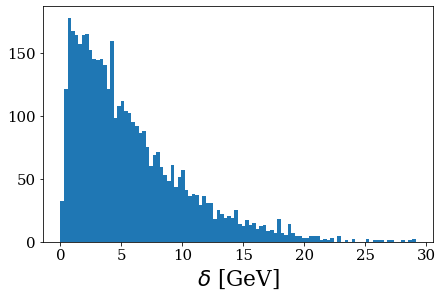

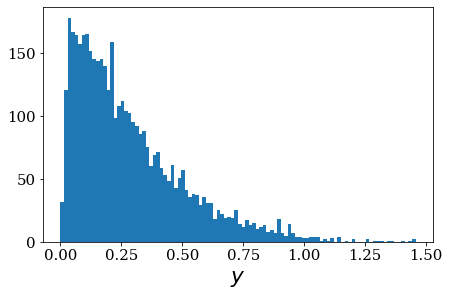

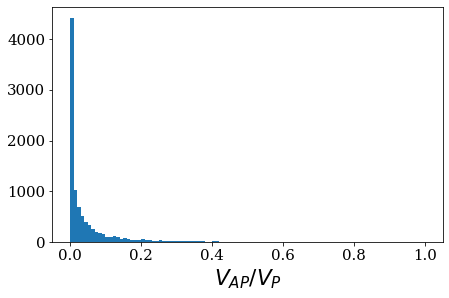

In [107]:
plt.hist(df_nu.JB_delta, bins=100); plt.gca().set_xlabel("$\\delta$ [GeV]")
plt.show()
plt.hist(df_nu.JB_y, bins=100); plt.gca().set_xlabel("$y$")
plt.show()

plt.hist(df_nu.VAP/df_nu.VP, bins=100, range=(0,1)); plt.gca().set_xlabel("$V_{AP}/V_P$")
plt.show()

In [95]:
30/(2*27.5)

0.5454545454545454

In [152]:
np.min(df_jets.Gen_Q2)

49.99386692989624